# Milestone Project: SkimLit
Based off and trimmed from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb. Credit to MrdBourke.

## Downloading our data

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [2]:
import os
DATA_DIR = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'
os.listdir('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign')

['dev.txt', 'test.txt', 'train.txt']

In [3]:
def get_lines(filename):
    '''
    Purpose: read lines from a file.
    '''
    
    with open(filename, 'r') as f:
        return f.readlines()            # Returns a list with each line of file.

In [4]:
train_lines = get_lines(DATA_DIR + '/train.txt')
train_lines[0:20]  # Looking at first 15 lines of train.txt.

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [5]:
# Make a preprocessing function to put line designation, line number, and line content into dicts.
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""  # Init the buffer for a block.
    abstract_samples = []  # Init the list of abstract results
    
    for line in input_lines:
        if line.startswith('###'):  # Indicates start of a block
            abstract_id = line
            abstract_lines = ""  # Reset buffer
        elif line.isspace():  # Indicates end of a block
            abstract_line_split = abstract_lines.splitlines()  # Splits each line by tab delim.
            
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')  # Split label from text
                line_data['target'] = target_text_split[0]  # Get target label
                line_data['text'] = target_text_split[1]  # Get target text
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        
        else: 
            abstract_lines += line
        
    return abstract_samples

In [6]:
preprocess_text_with_line_numbers(DATA_DIR + '/train.txt')

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [7]:
import pandas as pd
train_df = pd.DataFrame.from_dict(preprocess_text_with_line_numbers(DATA_DIR + '/train.txt'))
test_df = pd.DataFrame.from_dict(preprocess_text_with_line_numbers(DATA_DIR + '/test.txt'))
val_df = pd.DataFrame.from_dict(preprocess_text_with_line_numbers(DATA_DIR + '/dev.txt'))

In [8]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [9]:
# See how many of each class there are
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

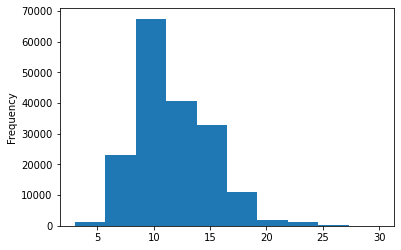

In [10]:
train_df.total_lines.plot.hist()

In [11]:
# Get a list of sentences.
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

### Use sklearn's LabelEncoder and OneHotEncoder

In [12]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))

In [13]:
train_df['target'].to_numpy().reshape(-1, 1).shape, train_labels_one_hot.shape

((180040, 1), (180040, 5))

In [14]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## Model 0: SKLearn TF-IDF Multinomial Naive Bayes

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences, 
            y=train_labels_encoded)

model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [16]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [17]:
# Import helper script
!curl -O https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 10246    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10246  100 10246    0     0  69395      0 --:--:-- --:--:-- --:--:-- 69700


In [18]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing data for deep sequence tf models

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [20]:
# Find out how long each sentence is on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = tf.reduce_mean(np.array(sent_lens).astype('float32'))
print(avg_sent_len)

tf.Tensor(26.33827, shape=(), dtype=float32)


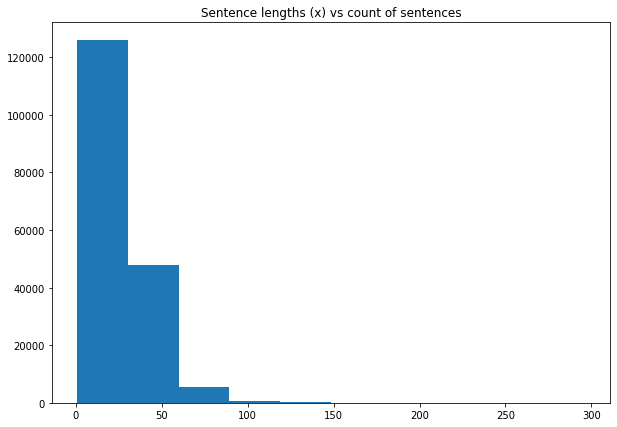

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.hist(sent_lens, bins=10)
plt.title('Sentence lengths (x) vs count of sentences')
plt.show()

In [22]:
# Get the 95th percentile of our sentence lengths.
output_seq_len = int(np.percentile(np.array(sent_lens).astype('float32'), 95))
output_seq_len

55

### Creating a text vectorizer

In [23]:
MAX_TOKENS = 60000

from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = MAX_TOKENS, 
                                    output_sequence_length = output_seq_len)

text_vectorizer.adapt(train_sentences)  # Train the text vectorizer. Assigns a number to a word.

In [24]:
import random
target_sentence = random.choice(train_sentences)
print(f'Text: \n{target_sentence}')
print(f'Length of text: {len(target_sentence.split())}')
print(f'Vectorization: \n{text_vectorizer([target_sentence])}')

Text: 
This issue may be particularly relevant in asymptomatic diabetes patients detected earlier in the course of the disease .
Length of text: 19
Vectorization: 
[[  23 3813   91   36 1057  963    5 2189  223   12  720 1448    5    2
   656    4    2  114    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [25]:
text_vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'of',
 'in',
 'to',
 'with',
 'a',
 'were',
 'was',
 'for',
 'patients',
 'group',
 'p',
 'at',
 'or',
 'study',
 'on',
 'treatment',
 'is',
 'after',
 'by',
 'this',
 'groups',
 'as',
 'an',
 'from',
 'that',
 'randomized',
 'between',
 'not',
 'trial',
 'no',
 'compared',
 'control',
 'be',
 'significant',
 'intervention',
 'significantly',
 'n',
 'months',
 'than',
 'we',
 'vs',
 'rsb',
 'lsb',
 'clinical',
 'placebo',
 'baseline',
 'ci',
 'two',
 'during',
 'weeks',
 'both',
 'had',
 'primary',
 'mean',
 'are',
 'using',
 'participants',
 'there',
 'all',
 'time',
 'years',
 'pain',
 'therapy',
 'who',
 'mg',
 'more',
 'effect',
 'effects',
 'but',
 'risk',
 'difference',
 'outcomes',
 'total',
 'care',
 'rate',
 'efficacy',
 'received',
 'associated',
 'higher',
 'respectively',
 'days',
 'analysis',
 'outcome',
 'use',
 'one',
 'week',
 'women',
 'may',
 'randomly',
 'levels',
 'followup',
 'will',
 'increased',
 'health',
 'used',
 'have',
 'data'

### Create a custom token embedding

In [26]:
token_embed = layers.Embedding(input_dim = len(text_vectorizer.get_vocabulary()),
                               output_dim = 128,
                               mask_zero=True,
                               name='token_embedding')

print(f'Sentence before vectorization: \n{target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization: \n{vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding: \n{embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization: 
This issue may be particularly relevant in asymptomatic diabetes patients detected earlier in the course of the disease .

Sentence after vectorization: 
[[  23 3813   91   36 1057  963    5 2189  223   12  720 1448    5    2
   656    4    2  114    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding: 
[[[ 0.02867385  0.02825472 -0.0086743  ...  0.00471505 -0.03436203
   -0.00592002]
  [ 0.03357358  0.02852312 -0.03244694 ... -0.03319921  0.00315424
   -0.0255972 ]
  [-0.00801364  0.02588568  0.00250732 ... -0.03235179 -0.04717493
    0.02624656]
  ...
  [-0.03654687  0.0038292  -0.03110496 ... -0.01430438  0.00427034
   -0.02826507]
  [-0.03654687  0.0038292  -0.03110496 ... -0.01430438  0.00427034
   -0.02826507]
  [-0.03654687  0.0038292  -0.03110496 ... -0.01430438  0.00427034
   -0.0282650

### Create datasets

In [27]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [28]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Creating character level embeddings

In [29]:
def split_chars(text):
    return " ".join(list(text))

split_chars(target_sentence)

'T h i s   i s s u e   m a y   b e   p a r t i c u l a r l y   r e l e v a n t   i n   a s y m p t o m a t i c   d i a b e t e s   p a t i e n t s   d e t e c t e d   e a r l i e r   i n   t h e   c o u r s e   o f   t h e   d i s e a s e   .'

In [30]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .


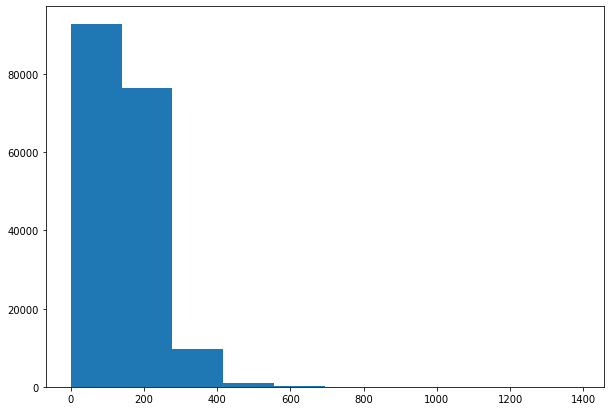

290


In [31]:
char_lens = [len(sentence) for sentence in train_sentences]
plt.figure(figsize=(10,7))
plt.hist(char_lens, bins=10)
plt.show()

# Calculate 95 percentile of lens
output_seq_char_len = np.percentile(np.array(char_lens).astype('int'), 95).astype('int')
print(output_seq_char_len)

In [32]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(f'Entire alphabet of ascii_lowercase + digits + punctuation: \n{alphabet}')

Entire alphabet of ascii_lowercase + digits + punctuation: 
abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [33]:
NUM_CHAR_TOKENS = len(alphabet) + 2  # Add 2 for OOV and space tokens.

char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                                    output_sequence_length = int(output_seq_char_len),
                                                    #output_mode = 'int',
                                                    standardize = 'lower_and_strip_punctuation',
                                                    name='char_vectorizer')

char_vectorizer.adapt(train_chars)

In [34]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab

['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q',
 'j']

### Now creating character level embeddings, after tokenizing

In [35]:
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                              output_dim = 25,
                              mask_zero = False,
                              name = 'char_embed')


random_train_chars = random.choice(train_chars)

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
T h e   l a t t e r   c o u l d   b e   b r o k e n   d o w n   i n t o   @   s u b t h e m e s   (   `   i n i t i a t i n g   d i s c u s s i o n   w i t h   f a m i l y   a n d   f r i e n d s   '   ,   `   a c c e p t a n c e   o f   f a m i l y   r u l e s   '   ,   `   i n c r e a s e d   r e s p o n s i b i l i t y   '   a n d   `   t h e   i m p o r t a n c e   o f   t h e   m o d e   a n d   a g e n t   o f   d e l i v e r y   '   )   .

Embedded chars (after vectorization and embedding):
[[[ 0.00730499  0.01964909 -0.03491344 ... -0.03944123  0.00795684
   -0.04957151]
  [-0.00312022  0.02694868 -0.04736231 ...  0.02624578 -0.00901312
   -0.04077177]
  [ 0.03996874  0.04771242 -0.02140589 ...  0.01503635 -0.03141788
    0.04406292]
  ...
  [ 0.02139025 -0.01269807 -0.0128697  ...  0.01959508  0.0202044
   -0.00224804]
  [ 0.02139025 -0.01269807 -0.0128697  ...  0.01959508  0.0202044
   -0.00224804]
  [ 0.02139025 -0.0126980

## Combining token and char data into tf.data dataset

In [36]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [37]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

## Create positional embeddings

In [38]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [39]:
NUM_POSITIONS = 15  # Set this to 15 as most abstracts have 15 or less lines
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [40]:
# Do the same as above for total lines
train_df['total_lines'].value_counts().rename_axis('unique_values').reset_index().to_numpy()

array([[   11, 24468],
       [   10, 23639],
       [   12, 22113],
       [    9, 19400],
       [   13, 18438],
       [   14, 14610],
       [    8, 12285],
       [   15, 10768],
       [    7,  7464],
       [   16,  7429],
       [   17,  5202],
       [    6,  3353],
       [   18,  3344],
       [   19,  2480],
       [   20,  1281],
       [    5,  1146],
       [   21,   770],
       [   22,   759],
       [   23,   264],
       [    4,   215],
       [   24,   200],
       [   25,   182],
       [   26,    81],
       [   28,    58],
       [    3,    32],
       [   30,    31],
       [   27,    28]], dtype=int64)

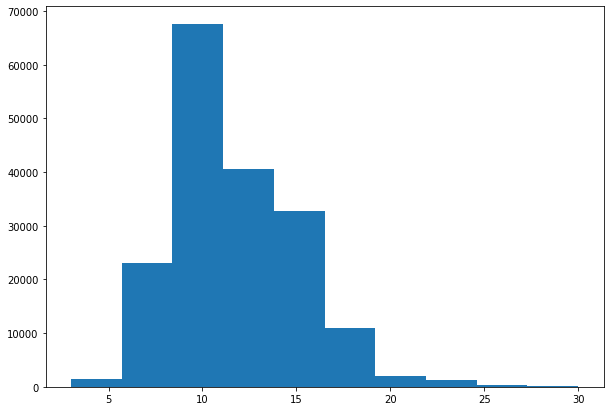

20.0

In [41]:
plt.figure(figsize=(10,7))
plt.hist(train_df['total_lines'], bins=10)
plt.show()


output_seq_len_total_lines = np.percentile(train_df['total_lines'].to_numpy(), 98)
output_seq_len_total_lines


In [42]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)


## Building datasets for tribid model

In [43]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

## Building tribrid model

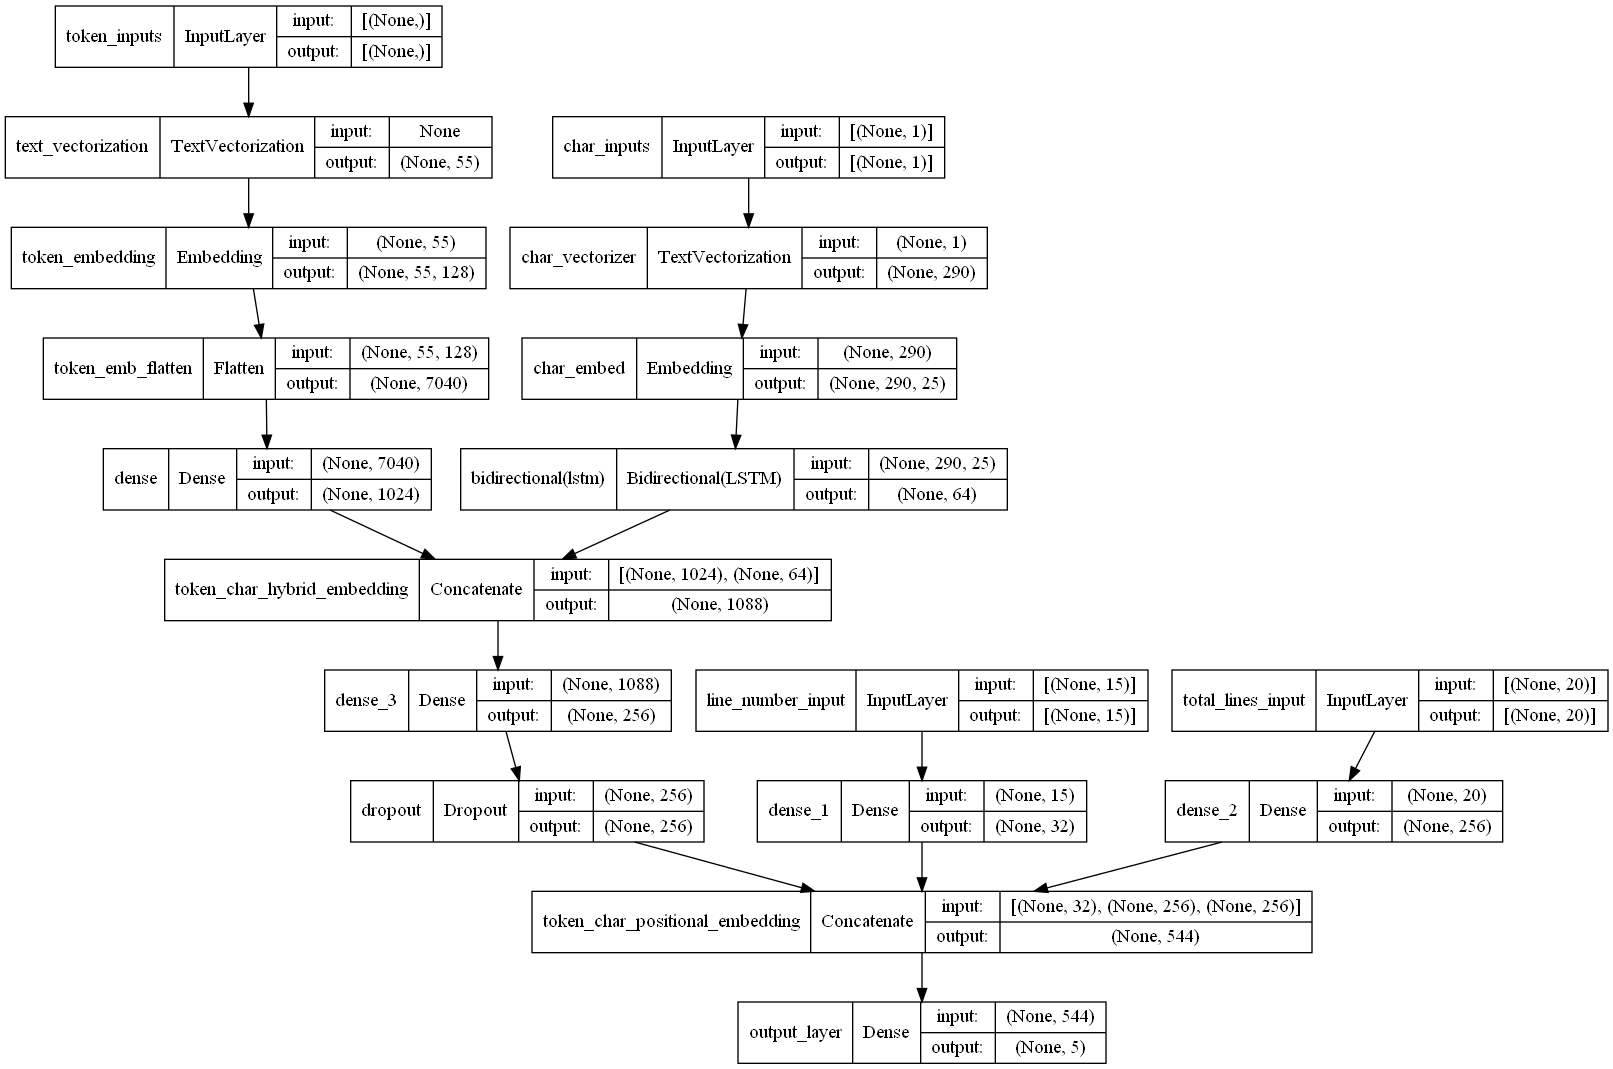

In [44]:
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
text_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(text_vectors)
token_emb_flatten = tf.keras.layers.Flatten(name='token_emb_flatten')(token_embeddings)
token_outputs = layers.Dense(1024, activation='relu')(token_emb_flatten)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)


char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

line_number_inputs = layers.Input(shape=(NUM_POSITIONS,), dtype=tf.int32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs = x)

total_lines_inputs = layers.Input(shape=(int(output_seq_len_total_lines),), dtype=tf.int32, name='total_lines_input')
x2 = layers.Dense(256, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=x2)

combined_embeddings = layers.Concatenate(name='token_char_hybrid_embedding')([token_model.output,
                                                                              char_model.output])  # Combine token and char model outputs. Smushes both outputs into one big tensor.

z = layers.Dense(256, activation='relu')(combined_embeddings)
z2 = layers.Dropout(0.5)(z)

z3 = layers.Concatenate(name='token_char_positional_embedding')([line_number_model.output,
                                                                 total_line_model.output,
                                                                 z2])

output_layer = layers.Dense(5, activation='softmax', name='output_layer')(z3)

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs = output_layer)


tf.keras.utils.plot_model(model_5, show_shapes=True)

In [45]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 36s 52ms/step - loss: 1.0911 - accuracy: 0.7238 - val_loss: 0.9367 - val_accuracy: 0.8314
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.9386 - accuracy: 0.8369 - val_loss: 0.9163 - val_accuracy: 0.8454
Epoch 3/3
562/562 [==============================] - 28s 51ms/step - loss: 0.9216 - accuracy: 0.8464 - val_loss: 0.9039 - val_accuracy: 0.8514
